In [76]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
import pandas as pd
import random

In [82]:
clf_dict = {'LR':LogisticRegression, 
           'GB':GradientBoostingClassifier}

In [188]:
data_dict={}
state='SD'
data_dict[state] = {}
for year in ['2014', '2015', '2016', '2017', '2018']: 
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]['x'] = features
    data_dict[state][year]['y'] = label
    data_dict[state][year]['g'] = group 

In [ ]:
# acoss years
results = [] 
for clf in clf_dict: 
    for i in range(5): 
        year = '2014'
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[state][year]['x'],
                    data_dict[state][year]['y'], 
                    data_dict[state][year]['g'], test_size=0.2, random_state=i)

        model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)
        
        yhat = model.predict(X_test)
        white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
        black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

        results.append({
            'year': year, 
            'test_acc': model.score(X_test, y_test), 
            'EO': white_tpr - black_tpr, 
            'size': len(y_train), 
            'run': run, 
        })
        for year in data_dict[state].keys(): 
            
            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[state][year]['x'],
                    data_dict[state][year]['y'], 
                    data_dict[state][year]['g'], test_size=0.4, random_state=i)
            yhat = model.predict(X_test)
            white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
            black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])
        
            results.append({
            'year': year, 
            'test_acc': model.score(X_test, y_test), 
            'EO': white_tpr - black_tpr, 
            'size': len(y_train), 
            'run': run, 
            'clf': clf,
        })

Text(0.5, 1.0, 'EO of 2014 model on future years Income')

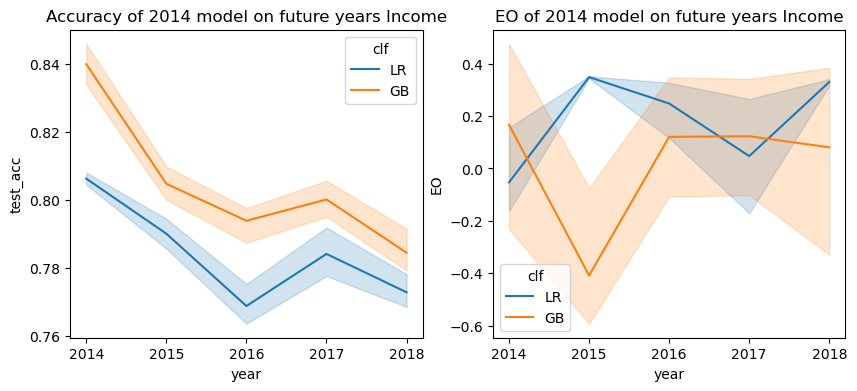

In [190]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(data=results_df, x='year', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy of 2014 model on future years Income")
sns.lineplot(data=results_df, x='year', y='EO', hue='clf', ax=axes[1])
axes[1].set_title("EO of 2014 model on future years Income")

In [ ]:
data_dict={}
state='KS'
year='2014'

for state in ['DC', 'CA', 'HI', 'SD', 'PA', 'MI', 'GA', 'MS']: 
    data_dict[state] = {}
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]['x'] = features
    data_dict[state][year]['y'] = label
    data_dict[state][year]['g'] = group 

In [160]:
# acoss states
results = [] 
year='2014'
for clf in clf_dict: 
    for i in range(5): 
        ref_state = 'CA'
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[ref_state][year]['x'],
                    data_dict[ref_state][year]['y'], 
                    data_dict[ref_state][year]['g'], test_size=0.2, random_state=i)

        model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)
        
        yhat = model.predict(X_test)
        white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
        black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

        results.append({
            'year': year, 
            'state': ref_state, 
            'test_acc': model.score(X_test, y_test), 
            'EO': white_tpr - black_tpr, 
            'size': len(y_train), 
            'run': run, 
            'clf': clf,
        })
        for state in data_dict.keys(): 
            if state != ref_state: 
                X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                        data_dict[state][year]['x'],
                        data_dict[state][year]['y'], 
                        data_dict[state][year]['g'], test_size=0.4, random_state=i)
                yhat = model.predict(X_test)
                white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
                black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

                results.append({
                'year': year, 
                'state': state, 
                'test_acc': model.score(X_test, y_test), 
                'EO': white_tpr - black_tpr, 
                'size': len(y_train), 
                'run': run, 
                'clf': clf,
            })

Text(0.5, 1.0, 'EO of 2014 CA model on other states')

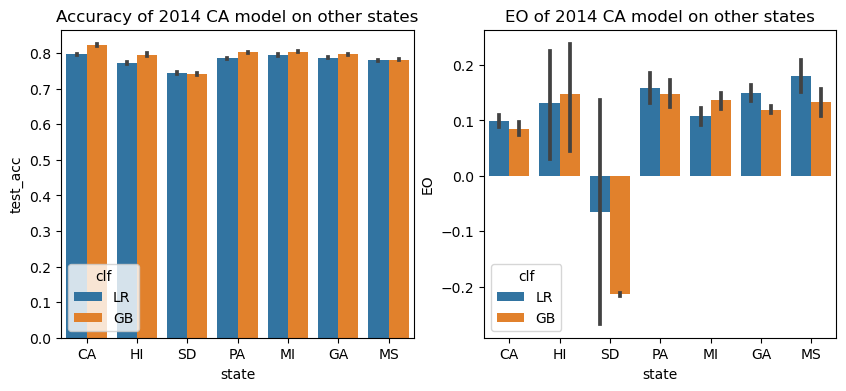

In [161]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=results_df, x='state', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title(f"Accuracy of 2014 {ref_state} model on other states")
sns.barplot(data=results_df, x='state', y='EO', hue='clf', ax=axes[1])
axes[1].set_title(f"EO of 2014 {ref_state} model on other states")

In [165]:
results_df.groupby('state').mean()

/var/folders/jc/ctcxyx_55yqb7m0dg7sj4clm0000gn/T/ipykernel_59709/319212009.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('state').mean()


,test_acc,EO,size,run
state,,,,
CA,0.810340,0.091578,147152.0,4.0
GA,0.792122,0.133833,28101.0,4.0
HI,0.784028,0.139164,4459.0,4.0
MI,0.799509,0.122489,28732.0,4.0
MS,0.781157,0.156442,7625.0,4.0
PA,0.794338,0.152955,39924.0,4.0
SD,0.743286,-0.139213,2848.0,4.0


In [167]:
results = [] 
state='SD'
year='2014'
size_arr = [50, 100, 500, 1000, 2000]
for clf in clf_dict.keys(): 
    for size in size_arr: 
        print(size)
        for run in range(5): 
            

            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                data_dict[state][year]['x'], 
                data_dict[state][year]['y'], 
                data_dict[state][year]['g'], test_size=0.2, random_state=0)
            
            incl = np.asarray(random.sample(range(len(y_train)), size))
            
            X_train = X_train[incl]
            y_train = y_train[incl]
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_train, y_train)
            
            yhat = model.predict(X_test)
            white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
            black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'EO': white_tpr - black_tpr, 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

50
100
500
1000
2000
50
100
500
1000
2000


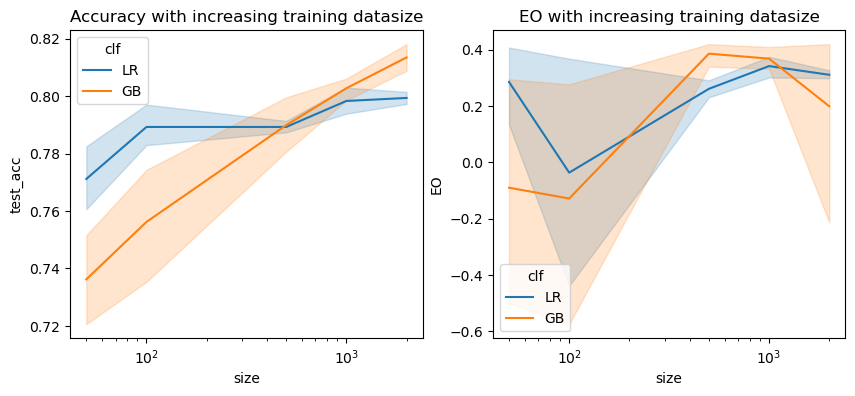

In [168]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy with increasing training datasize")
axes[0].set_xscale('log')
sns.lineplot(data=results_df, x='size', y='EO', hue='clf', ax=axes[1])
axes[1].set_title("EO with increasing training datasize")
axes[1].set_xscale('log')

In [ ]:
# sequential

results = [] 
state='SD'
year='2014'
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000, 12000, 14000]
for run in range(5): 
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]['x'], 
        data_dict[state][year]['y'], 
        data_dict[state][year]['g'], test_size=0.2, random_state=run)

    X_joint = np.concatenate((X_train, 
                            data_dict['CA'][year]['x']))
    y_joint = np.concatenate((y_train, 
                            data_dict['CA'][year]['y']))
    g_joint = np.concatenate((group_train, 
                            data_dict['CA'][year]['g']))

    for clf in clf_dict.keys(): 

        for size in size_arr: 
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            yhat = model.predict(X_test)
            white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
            black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'EO': white_tpr - black_tpr, 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

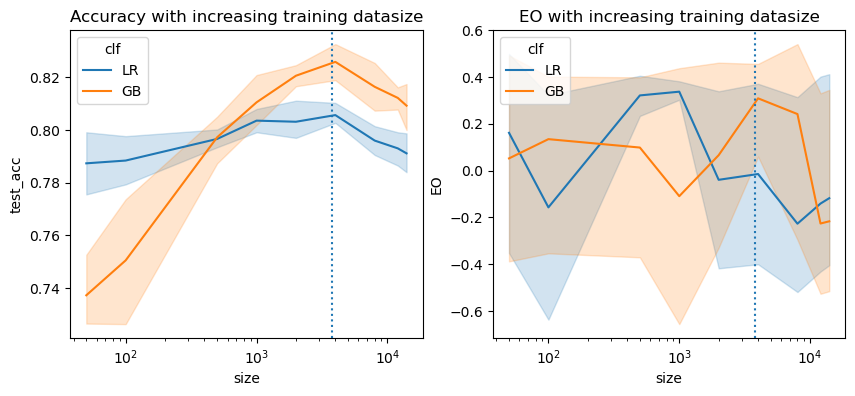

In [180]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy with increasing training datasize")
axes[0].set_xscale('log')
axes[0].axvline(x=len(X_train), linestyle=':')
sns.lineplot(data=results_df, x='size', y='EO', hue='clf', ax=axes[1])
axes[1].set_title("EO with increasing training datasize")
axes[1].set_xscale('log')
axes[1].axvline(x=len(X_train), linestyle=':')